In [3]:
from IPython.display import display
import scipy.stats as stats
import numpy as np
from numpy import mean
from numpy import var
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
import neurokit2 as nk
import warnings
warnings.filterwarnings('ignore')

from lists import dyads, num_dyads, participants, num_participants

In [4]:
# Set sampling rate
sampling_rate = 2000
print("Sampling rate:", sampling_rate)

# Set conditions
condition = ["sit","gaze"]
print("Conditions:", condition)

# Show number of participants
print("Participants:", num_participants)

# Show number of dyads
print("Dyads:", num_dyads)

Sampling rate: 2000
Conditions: ['sit', 'gaze']
Participants: 8
Dyads: 4


In [5]:
rmssd = {}
hr = {}

for con in condition:
    ecg_raw_2000hz = np.load(f"data/ecg_raw/ecg_raw_{con}.npy")
    ecg = [
        nk.ecg_clean(ecg_raw_2000hz[j],
                    sampling_rate=sampling_rate, 
                    method="neurokit")
        for j in participants
    ]
    r_peaks = [
        nk.ecg_peaks(ecg[j], sampling_rate=sampling_rate, method="neurokit", correct_artifacts=True)
        for j in participants
    ]
    hrv = [nk.hrv(r_peaks[j], sampling_rate=2000, show=False)
        for j in participants
    ]
    
    rmssd[con] = [
        hrv[j]["HRV_RMSSD"][0]
        for j in participants
    ]
    hr[con] = [
        sum(r_peaks[j][0]["ECG_R_Peaks"])/((len(ecg[j])/(sampling_rate*60)))
        for j in participants
    ]


In [6]:
for con in condition:
    print(f"Average heart rates per person in condition {con.upper()}")
    # Save data as 3D array
    for k, idx in enumerate(participants[::2]): # index for dyads
        print(f"Dyad {k} | Female: {hr[con][idx]} Male: {hr[con][idx+1]}")
        
# Build dataframe
print("\nAverage heart rates and SD over all participants")
heartrate_mean = pd.DataFrame(
    {"Female": [np.mean(hr["sit"][0::2]), 
                np.mean(hr["gaze"][0::2]), 
                np.mean([*hr["sit"][0::2],
                         *hr["gaze"][0::2]])],
     "Male": [np.mean(hr["sit"][1::2]), 
              np.mean(hr["gaze"][1::2]), 
              np.mean([*hr["sit"][1::2],
                       *hr["gaze"][1::2]])],
     "All":  [np.mean(hr["sit"]), 
                np.mean(hr["gaze"]), 
                np.mean([*hr["sit"],
                         *hr["gaze"]])]},
    index=["SIT", "GAZE", "All"])
heartrate_mean = heartrate_mean.round(1)
print(heartrate_mean.T)

Average heart rates per person in condition SIT
Dyad 0 | Female: 72.4 Male: 60.2
Dyad 1 | Female: 70.0 Male: 69.6
Dyad 2 | Female: 92.6 Male: 76.2
Dyad 3 | Female: 82.0 Male: 77.2
Average heart rates per person in condition GAZE
Dyad 0 | Female: 70.8 Male: 60.8
Dyad 1 | Female: 73.4 Male: 66.8
Dyad 2 | Female: 91.6 Male: 78.4
Dyad 3 | Female: 74.8 Male: 72.6

Average heart rates and SD over all participants
         SIT  GAZE   All
Female  79.2  77.6  78.4
Male    70.8  69.6  70.2
All     75.0  73.6  74.3


In [7]:
# Function to calculate Cohen's d for independent samples
# based on https://machinelearningmastery.com/effect-size-measures-in-python/
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = mean(d1), mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

In [8]:
# Calculate Cohen's d between two samples
d_sit = cohend(hr["sit"][0::2], 
               hr["sit"][1::2])
d_gaze = cohend(hr["gaze"][0::2], 
               hr["gaze"][1::2])

print('\nCohens d SIT: %.3f' %d_sit,
      '\nCohens d GAZE: %.3f' %d_gaze)


Cohens d SIT: 0.924 
Cohens d GAZE: 0.935


In [9]:
def confidence_interval(data, distribution, confidence=0.95):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    std = np.std(a,ddof=1)
    se = np.array(std/(n**(1/2)))
    if distribution == "t":
        # hw = half-width
        hw_upper = hw_lower = se * st.t.ppf((1+confidence)/2, n-1)
    elif distribution == "chi2":
        hw_upper = se * st.chi2.ppf((1+confidence)/2, n-1)
        hw_lower = se * st.chi2.ppf(1-(1+confidence)/2, n-1)
   
    return m, m+hw_upper, m-hw_lower

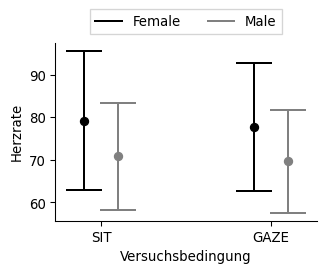

In [10]:
horizontal_line_width=len(condition)*0.1

fig = plt.figure(figsize=(3.5,3), dpi=96)
for j,con in enumerate(["sit","gaze"]):
    for i,sex in enumerate(["Female","Male"]): 
        if sex == "Female":
            dis = 0
            color = "k"
        elif sex == "Male":
            dis = 0.2
            color = "grey"
        m, upper, lower = confidence_interval(list(hr[con][i::2]),"t", 0.95)
        plt.plot(dis+j, m, 'o', color=color)
        plt.plot([dis+j, dis+j], [upper, lower], color=color, label = sex if j == 0 else "")
        # Horizontal bar
        left = dis+j - horizontal_line_width / 2
        right = dis+j + horizontal_line_width / 2
        plt.plot([left, right], [upper, upper], color=color)
        plt.plot([left, right], [lower, lower], color=color)
    plt.xticks([0+dis/2, 1+dis/2], ['SIT', 'GAZE'])
    plt.ylabel('Herzrate')
    plt.xlabel('Versuchsbedingung')
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.12), fancybox=False, shadow=False, ncol=2)
        
fig.tight_layout()
sns.despine()
plt.savefig("plots/hr_mean.png", dpi=512, bbox_inches='tight')

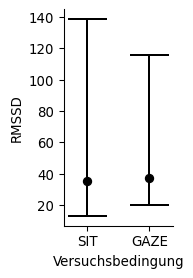

In [15]:
horizontal_line_width=len(condition)*0.3
color="k"

fig = plt.figure(figsize=(2,3), dpi=96)
for j,con in enumerate(["sit","gaze"]):
    m, upper, lower = confidence_interval(list(rmssd[con])*1,"chi2", 0.95)
    plt.plot(j, m, 'o', color=color)
    plt.plot([j, j], [upper, lower], color=color)
    # Horizontal bar
    left = j - horizontal_line_width / 2
    right = j + horizontal_line_width / 2
    plt.plot([left, right], [upper, upper], color=color)
    plt.plot([left, right], [lower, lower], color=color)
    plt.xticks([0, 1], ['SIT', 'GAZE'])
    plt.ylabel('RMSSD')
    plt.xlabel('Versuchsbedingung')
        
fig.tight_layout()
sns.despine()
plt.savefig("plots/hr_mean.png", dpi=512, bbox_inches='tight')


In [14]:
# Calculate Cohen's d between two samples
d_rmssd = cohend(rmssd["sit"],
                 rmssd["gaze"])

print('\nCohens d RMSSD: %.3f' %d_rmssd)


Cohens d RMSSD: -0.084
